In [1]:
import sys

sys.path.append('../')

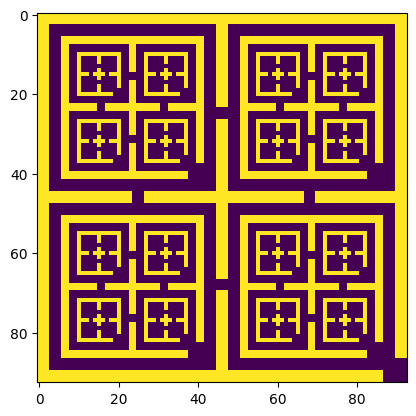

In [2]:
import numpy as np
import graphviz
from IPython.display import display
from environments.tree.tree import NaryTreeEnvironment
from environments.tree.discrete_maze import GridMazeEnvironment
from environments.tree.data import TrajectoryDataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import hypll
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
from hypll.optim import RiemannianAdam
import hypll.nn as hnn
from hypll.tensors import TangentTensor, ManifoldTensor

import argparse
from environments.tree.data import TrajectoryDataset, SetDataset
from environments.maze.data import set_collate_fn

from networks.hypnets import HyperbolicMLP, manifold_map
from networks.nets import SmallEncoder
from utils import get_maze, load_model, load_tree_model
import os
import json

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

saved = '/home/yongweic/hyperbolic/saved_models/set_experiment2_hyperbolic_True_curvature_1.0_epochs_150_trajectories_25000_order__depth_6_branch_2_embeddingdim_2_gamma_0.5_batch_128'
config = json.load(open(os.path.join(saved, 'config.json')))
print(config)

branching_factor = config['branching_factor']
depth = config['depth']

env = NaryTreeEnvironment(depth=depth, branching_factor=branching_factor)
hyperbolic = config['hyperbolic']
model_dict = load_tree_model(config, 
                             env.num_nodes, 
                             env.branching_factor + 2,  
                             device, pretrained_path=saved, 
                             epoch=32)

encoder1 = model_dict['encoder1']
encoder2 = model_dict['encoder2']
manifold = model_dict['manifold']


c = float(manifold.c.value)
print(f'curvature: {c}')

{'project': 'tree', 'custom': '2', 'env': 'tree', 'hyperbolic': True, 'embedding_dim': 2, 'curvature': 1.0, 'learnable_curvature': True, 'num_epochs': 150, 'num_trajectories': 25000, 'batch_size': 128, 'num_negatives': 64, 'max_steps': 100, 'num_workers': 24, 'learning_rate': 0.01, 'lr_scheduler_step_size': 32, 'lr_scheduler_gamma': 0.7, 'depth': 6, 'branching_factor': 2, 'gamma': 0.5, 'order_name': '', 'eval_trials': 10, 'temperature': 0.1, 'architecture': 'DeepSet'}
loading pretrained...
curvature: 14.743127822875977


In [5]:
dataset = SetDataset(depth=config['depth'],
                     branching_factor=config['branching_factor'],
                     num_trajectories=1000,
                     num_negatives=16,
                     gamma=config['gamma']
                    )

dataset[1]



set dataset gamma: 0.5


(array([[28]]), array([[28]]))

[[45]
 [22]
 [10]
 [ 4]
 [ 1]
 [ 0]
 [ 2]
 [ 6]
 [13]
 [27]
 [55]]
[[23]
 [11]
 [ 5]
 [ 2]
 [ 0]
 [ 1]
 [ 3]
 [ 7]
 [15]
 [32]]
[[4]
 [1]
 [3]
 [7]]
[[34]
 [16]
 [ 7]
 [ 3]
 [ 1]
 [ 0]
 [ 2]
 [ 6]
 [14]]
[[17]
 [ 8]
 [ 3]]
[[57]
 [28]
 [13]
 [ 6]
 [14]
 [30]
 [62]]
[[37]
 [18]
 [ 8]
 [ 3]
 [ 1]
 [ 0]
 [ 2]
 [ 6]
 [14]
 [30]
 [62]]
[[49]
 [24]
 [11]
 [ 5]
 [ 2]
 [ 6]
 [14]
 [30]
 [62]]
[[38]
 [18]
 [ 8]
 [ 3]
 [ 1]
 [ 0]
 [ 2]
 [ 6]
 [13]
 [28]]
[[19]
 [ 9]
 [ 4]
 [ 1]
 [ 3]
 [ 7]
 [15]
 [31]]
[[21]
 [10]
 [ 4]
 [ 1]
 [ 3]
 [ 7]
 [16]
 [34]]
[[40]
 [19]
 [ 9]
 [20]]
[[31]
 [15]
 [ 7]
 [ 3]
 [ 1]
 [ 4]
 [10]
 [21]
 [44]]
[[ 4]
 [ 1]
 [ 3]
 [ 8]
 [17]
 [35]]
[[39]
 [19]
 [ 9]
 [ 4]
 [ 1]
 [ 0]
 [ 2]
 [ 6]
 [13]
 [27]
 [55]]


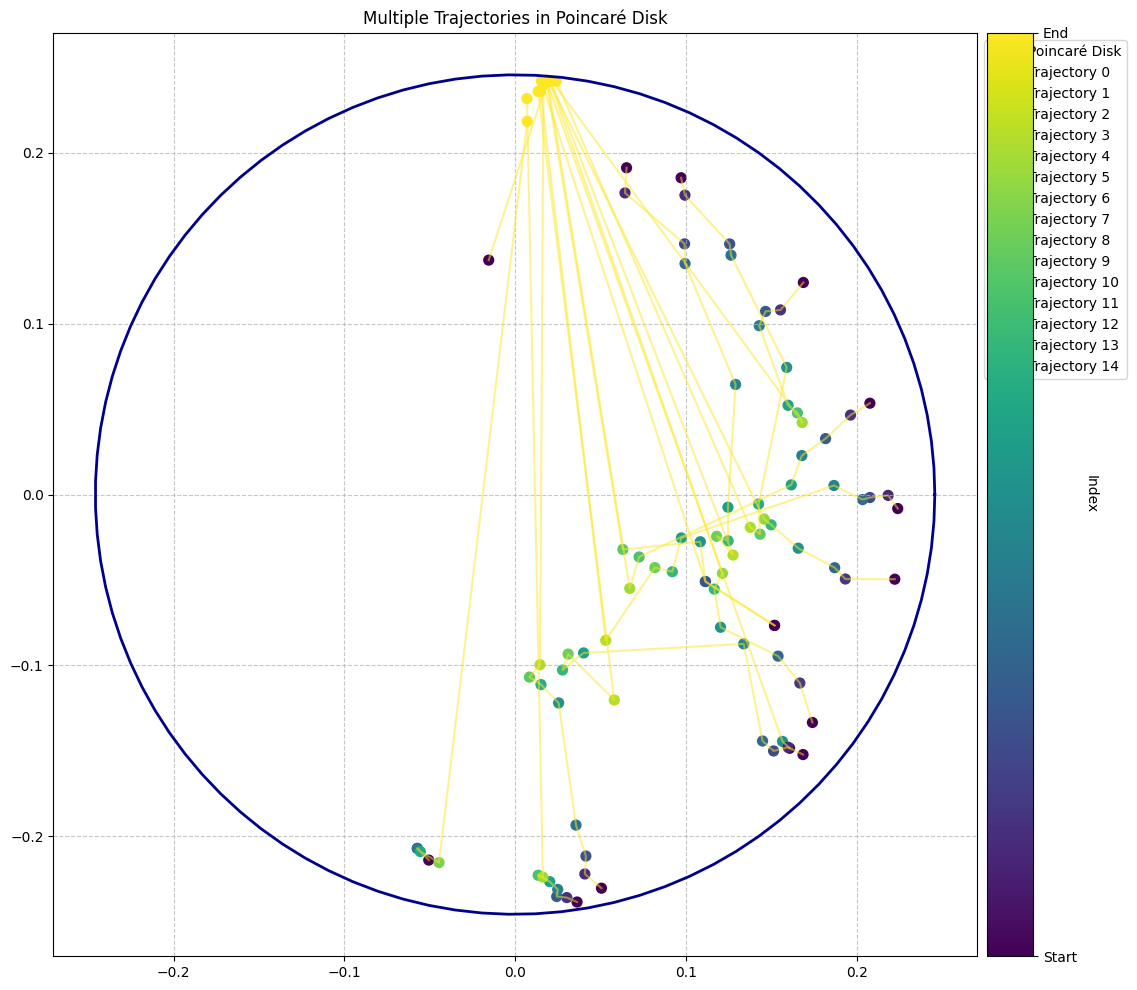

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Plot the Poincaré disk (unit circle)
theta = np.linspace(0, 2*np.pi, 100)
radius = float(1 / np.sqrt(c))
x_circle = np.cos(theta) * radius
y_circle = np.sin(theta) * radius
ax.plot(x_circle, y_circle, color='darkblue', label='Poincaré Disk', linewidth=2)

# Define a single colormap to be reused for each trajectory
cmap = plt.get_cmap('viridis')

max_range = radius  # Initialize max_range
max_len = 0  # To keep track of the longest trajectory

# Loop through multiple values of i
for idx, i in enumerate(range(15)):  # You can adjust this range as needed
    val = np.stack([x[0] for x in dataset.trajectories[i]])[:,None]
    print(val)
    l = []
    lens = []
    for j in range(1, val.shape[0]):
        l.append(val[:j])
        lens.append(j)
    batch = set_collate_fn([(x, x) for x in l])
    s = torch.as_tensor(batch['set1'], dtype=torch.int64, device=device)
    mask = torch.as_tensor(batch['set1_mask'], dtype=torch.int64, device=device)

    with torch.no_grad():
        res = encoder2(s, mask=mask)
        
        points = res.tensor
        # Convert tensor to numpy array if it's not already
        points_np = points.cpu().numpy() if hasattr(points, 'cpu') else points.numpy()

        # Create a color array for this trajectory
        colors = cmap(np.linspace(0, 1, len(points_np)))

        # Plot the points with color gradient
        scatter = ax.scatter(points_np[:, 0], points_np[:, 1], 
                   c=range(len(points_np)), cmap=cmap, 
                   s=50, label=f'Trajectory {i}')
        
        # Add a line connecting the points
        ax.plot(points_np[:, 0], points_np[:, 1], '-', 
                color=colors[-1], alpha=0.5)

        # Update max_range and max_len
        max_range = max(max_range,
                        np.max(np.abs(points_np[:, 0])),
                        np.max(np.abs(points_np[:, 1])))
        max_len = max(max_len, len(points_np))

# Add a small padding
padding = max_range * 0.1

# Set limits to center the plot
ax.set_xlim(-max_range - padding, max_range + padding)
# ax.set_xlim(0.05, 0.20)
ax.set_ylim(-max_range - padding, max_range + padding)

# Set aspect ratio to equal for a perfect circle
ax.set_aspect('equal')

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Set title and legend
ax.set_title('Multiple Trajectories in Poincaré Disk')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(scatter, cax=cax)
cbar.set_label('Index', rotation=270, labelpad=15)
cbar.set_ticks([0, max_len - 1])
cbar.set_ticklabels(['Start', 'End'])

# Adjust layout to make room for the legend and colorbar
plt.tight_layout()

# Show the plot
plt.show()

curvature: 16.553924560546875
[[45]
 [22]
 [10]
 [ 4]]
[[23]
 [11]
 [ 5]
 [ 2]]
[[4]
 [1]
 [3]
 [7]]
[[34]
 [16]
 [ 7]
 [ 3]]
[[17]
 [ 8]
 [ 3]]
[[57]
 [28]
 [13]
 [ 6]]
[[37]
 [18]
 [ 8]
 [ 3]]
[[49]
 [24]
 [11]
 [ 5]]
[[38]
 [18]
 [ 8]
 [ 3]]
[[19]
 [ 9]
 [ 4]
 [ 1]]
[[21]
 [10]
 [ 4]
 [ 1]]
[[40]
 [19]
 [ 9]
 [20]]
[[31]
 [15]
 [ 7]
 [ 3]]
[[4]
 [1]
 [3]
 [8]]
[[39]
 [19]
 [ 9]
 [ 4]]


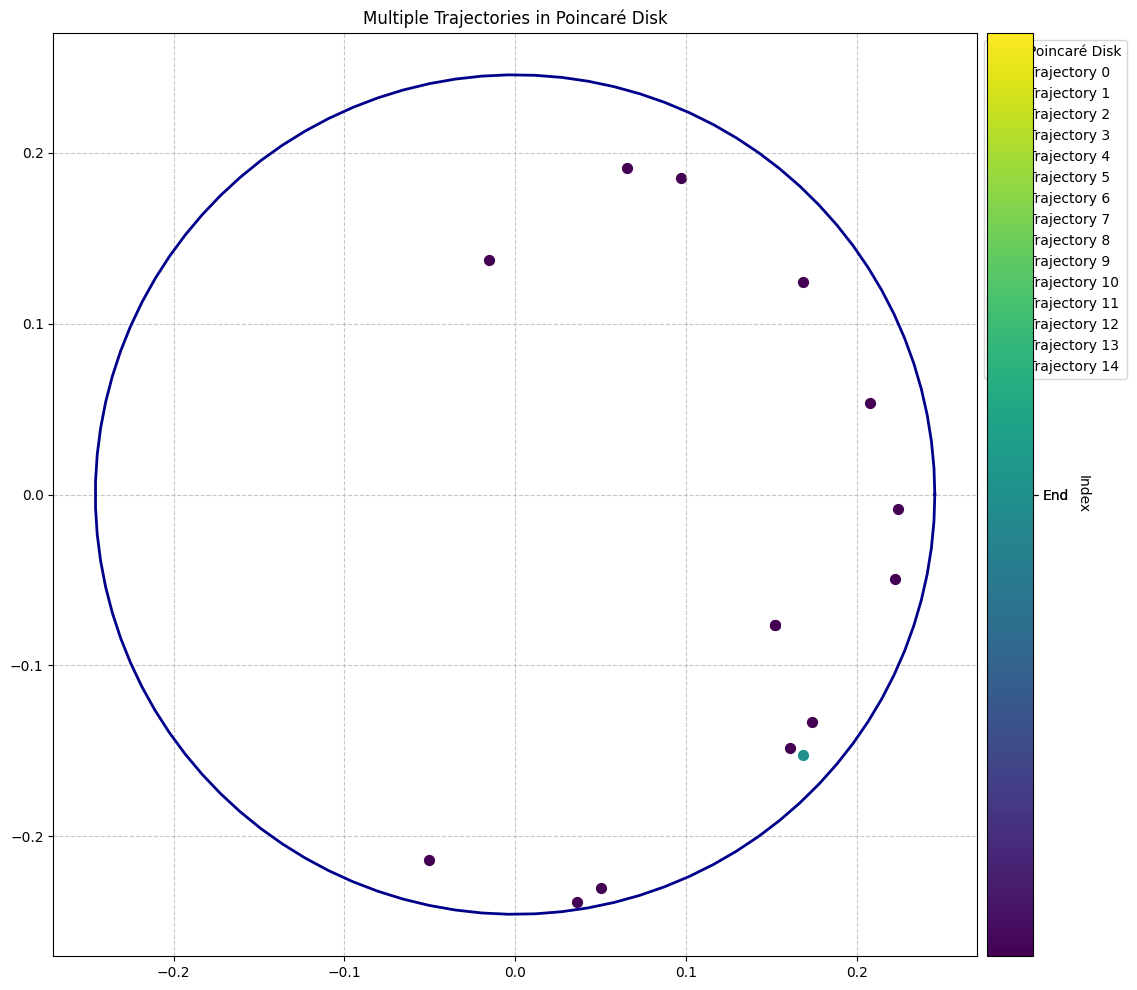

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

c = float(manifold.c.value)
print(f'curvature: {c}')

# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Plot the Poincaré disk (unit circle)
theta = np.linspace(0, 2*np.pi, 100)
radius = float(1 / np.sqrt(c))
x_circle = np.cos(theta) * radius
y_circle = np.sin(theta) * radius
ax.plot(x_circle, y_circle, color='darkblue', label='Poincaré Disk', linewidth=2)

# Define a single colormap to be reused for each trajectory
cmap = plt.get_cmap('viridis')

max_range = radius  # Initialize max_range
max_len = 0  # To keep track of the longest trajectory

# Loop through multiple values of i
for idx, i in enumerate(range(15)):  # You can adjust this range as needed
    val = np.stack([x[0] for x in dataset.trajectories[i]])[:4]
    val = val[:,None]
    print(val)
    l = []
    lens = []
    for j in range(1, val.shape[0]):
        l.append(val[:j])
        lens.append(j)
    batch = set_collate_fn([(x, x) for x in l])
    s = torch.as_tensor(batch['set1'], dtype=torch.int64, device=device)
    mask = torch.as_tensor(batch['set1_mask'], dtype=torch.int64, device=device)

    with torch.no_grad():
        res = encoder2(s, mask=mask)
        
        points = res.tensor[:1]
        # Convert tensor to numpy array if it's not already
        points_np = points.cpu().numpy() if hasattr(points, 'cpu') else points.numpy()

        # Create a color array for this trajectory
        colors = cmap(np.linspace(0, 1, len(points_np)))

        # Plot the points with color gradient
        scatter = ax.scatter(points_np[:, 0], points_np[:, 1], 
                   c=range(len(points_np)), cmap=cmap, 
                   s=50, label=f'Trajectory {i}')
        
        # Add a line connecting the points
        ax.plot(points_np[:, 0], points_np[:, 1], '-', 
                color=colors[-1], alpha=0.5)

        # Update max_range and max_len
        max_range = max(max_range,
                        np.max(np.abs(points_np[:, 0])),
                        np.max(np.abs(points_np[:, 1])))
        max_len = max(max_len, len(points_np))

# Add a small padding
padding = max_range * 0.1

# Set limits to center the plot
ax.set_xlim(-max_range - padding, max_range + padding)
# ax.set_xlim(0.05, 0.20)
ax.set_ylim(-max_range - padding, max_range + padding)

# Set aspect ratio to equal for a perfect circle
ax.set_aspect('equal')

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Set title and legend
ax.set_title('Multiple Trajectories in Poincaré Disk')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(scatter, cax=cax)
cbar.set_label('Index', rotation=270, labelpad=15)
cbar.set_ticks([0, max_len - 1])
cbar.set_ticklabels(['Start', 'End'])

# Adjust layout to make room for the legend and colorbar
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
for i in range(len(dataset.trajectories)):
    val = [x[0] for x in dataset.trajectories[i]]
    print(len(val))
    v = torch.tensor(val)[None,:,None]

    with torch.no_grad():
        p = encoder2(v, mask=torch.ones(v.shape[:2]))

    p.tensor

11
6
2
6
10
11
6
10
7
6
3
7
9
9
8
9
8
10
11
2
7
10
9
8
1
6
9
10
4
2
9
9
6
1
10
11
7
9
9
3
11
11
6
3
7
7
3
4
10
9
10
11
3
10
4
4
4
10
5
9
9
10
11
6
8
9
7
11
11
11
6
5
10
8
10
2
1
7
6
8
8
9
3
2
6
5
5
6
8
11
11
7
7
9
11
7
10
8
9
9
2
11
2
10
8
8
11
10
11
3
3
7
4
11
5
8
9
5
3
4
8
9
4
11
5
7
4
4
7
9
10
3
6
3
4
11
9
7
3
6
8
4
7
9
8
10
11
5
11
8
7
10
7
5
8
8
11
7
7
1
10
11
5
10
11
8
9
10
7
9
8
6
11
7
6
10
11
6
10
9
8
5
2
6
3
5
4
4
6
1
10
11
4
6
10
6
2
9
5
10
10
5
10
7
10
9
6
6
8
7
6
9
6
4
4
8
7
7
5
10
6
11
9
7
7
9
7
5
10
5
10
4
3
10
4
4
5
9
11
10
9
10
6
8
7
9
11
10
4
4
7
11
10
9
10
6
5
8
6
1
10
6
9
9
6
11
5
8
11
6
6
6
7
11
4
6
4
5
8
8
8
5
4
8
8
4
4
9
9
10
8
7
8
4
9
7
6
11
8
8
4
9
6
7
4
8
11
9
9
2
9
8
3
3
10
4
7
9
5
10
10
9
9
11
8
8
7
11
8
7
8
5
9
2
3
2
11
11
7
2
6
7
11
9
10
11
11
2
6
10
6
6
6
8
6
4
6
5
8
7
9
1
5
9
6
9
8
6
7
11
9
7
8
8
7
9
10
8
5
9
9
4
7
11
2
9
6
4
8
4
8
8
8
7
3
10
4
5
10
9
8
9
6
5
5
3
11
5
10
10
7
7
7
7
6
10
8
11
9
9
10
10
9
5
9
9
11
10
2
11
9
6
10
10
7
5
10
9
8
8
1
11
5
7
9
9

curvature: 14.743127822875977


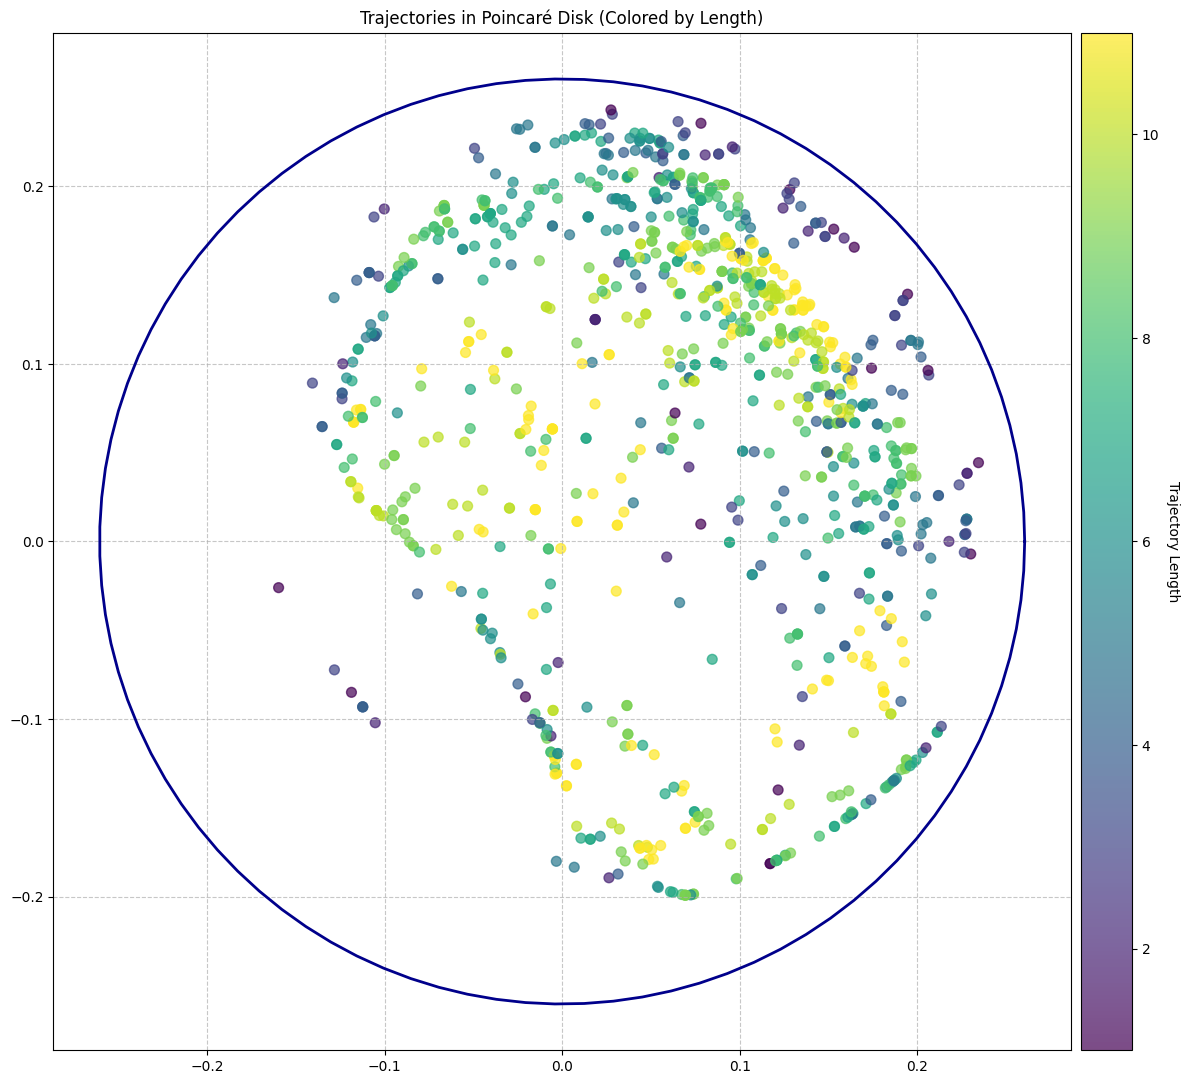

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

c = float(manifold.c.value)
print(f'curvature: {c}')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the Poincaré disk (unit circle)
theta = np.linspace(0, 2*np.pi, 100)
radius = float(1 / np.sqrt(c))
x_circle = np.cos(theta) * radius
y_circle = np.sin(theta) * radius
ax.plot(x_circle, y_circle, color='darkblue', label='Poincaré Disk', linewidth=2)

# Define a colormap for trajectory lengths
length_cmap = plt.get_cmap('viridis')

# Collect all points and their lengths
all_points = []
lengths = []

for i in range(len(dataset.trajectories)):
    val = [x[0] for x in dataset.trajectories[i]]
    v = torch.tensor(val)[None,:,None]
    with torch.no_grad():
        l = encoder2(v, mask=torch.ones(v.shape[:2]))
    point = l.tensor.cpu().numpy().squeeze()
    
    all_points.append(point)
    lengths.append(len(val))

# Convert to numpy arrays
all_points = np.array(all_points)
lengths = np.array(lengths)

# Normalize lengths for colormapping
norm_lengths = (lengths - lengths.min()) / (lengths.max() - lengths.min())

# Plot points
scatter = ax.scatter(all_points[:, 0], all_points[:, 1], 
                     c=lengths, cmap=length_cmap, 
                     s=50, alpha=0.7)

max_range = max(radius, np.max(np.abs(all_points)))

# Add a small padding
padding = max_range * 0.1

# Set limits to center the plot
ax.set_xlim(-max_range - padding, max_range + padding)
ax.set_ylim(-max_range - padding, max_range + padding)

# Set aspect ratio to equal for a perfect circle
ax.set_aspect('equal')

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Set title
ax.set_title('Trajectories in Poincaré Disk (Colored by Length)')

# Add colorbar for trajectory lengths
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(scatter, cax=cax)
cbar.set_label('Trajectory Length', rotation=270, labelpad=15)

# Adjust layout to make room for the colorbar
plt.tight_layout()

# Show the plot
plt.show()

curvature: 14.743127822875977


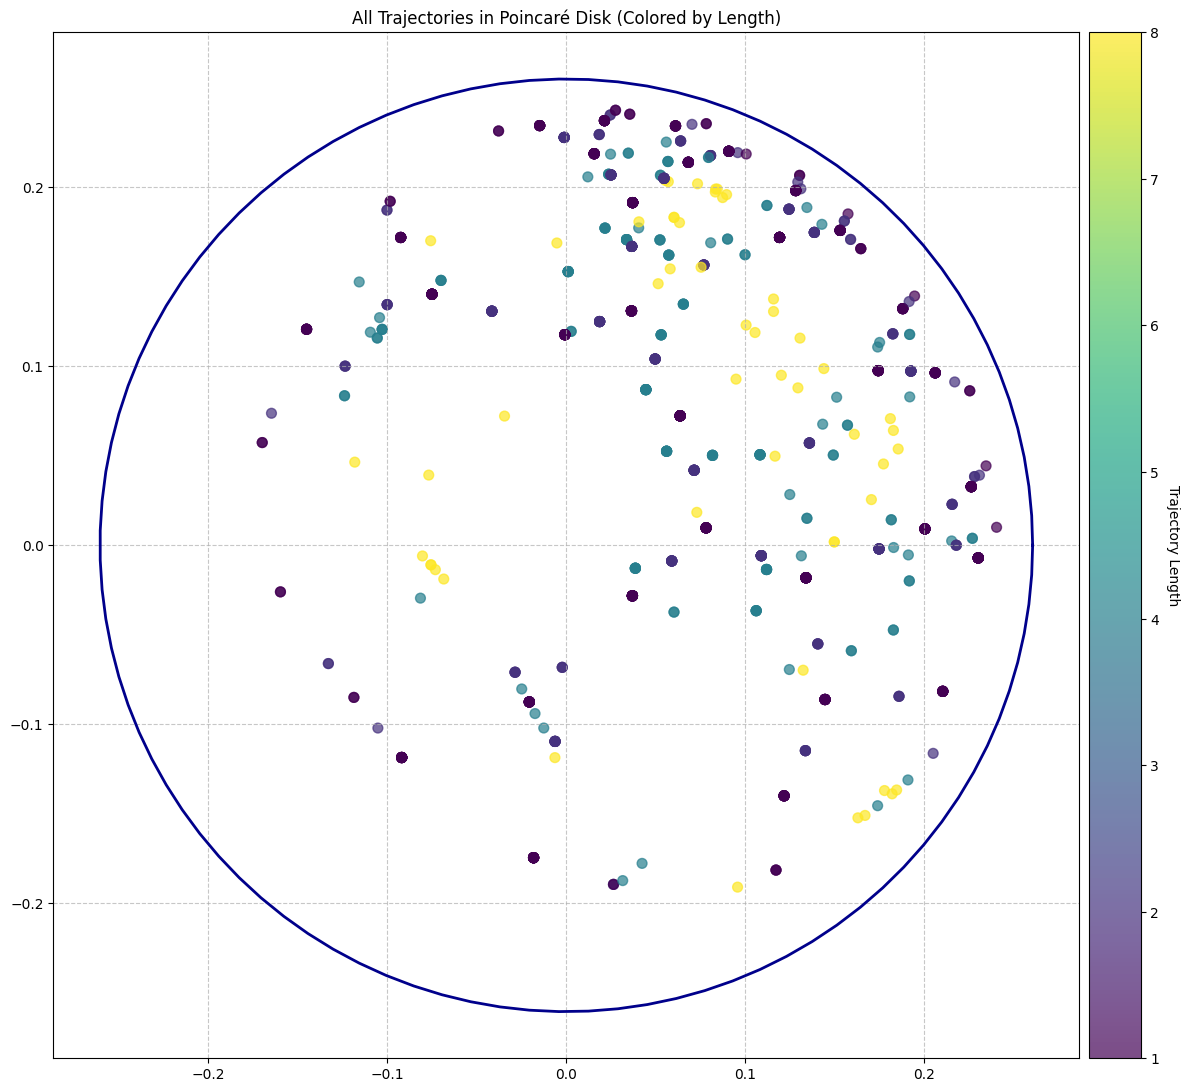

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_trajectories(dataset, encoder2, target_length=None):
    c = float(manifold.c.value)
    print(f'curvature: {c}')
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot the Poincaré disk (unit circle)
    theta = np.linspace(0, 2*np.pi, 100)
    radius = float(1 / np.sqrt(c))
    x_circle = np.cos(theta) * radius
    y_circle = np.sin(theta) * radius
    ax.plot(x_circle, y_circle, color='darkblue', label='Poincaré Disk', linewidth=2)
    
    # Define a colormap for trajectory lengths
    length_cmap = plt.get_cmap('viridis')
    
    # Collect all points and their lengths
    all_points = []
    lengths = []
    
    for i in range(len(dataset)):
        v = torch.tensor(dataset[i][0])[None,:]
        # val = [x[0] for x in dataset.trajectories[i]]
        if target_length is None or v.shape[1] == target_length:
            # print(v)
            with torch.no_grad():
                l = encoder2(v, mask=torch.ones(v.shape[:2], dtype=torch.bool))
            point = l.tensor.cpu().numpy().squeeze()
            
            all_points.append(point)
            lengths.append(v.shape[1])
    
    # Convert to numpy arrays
    all_points = np.array(all_points)
    lengths = np.array(lengths)
    
    if len(all_points) == 0:
        print(f"No trajectories found with length {target_length}")
        return
    
    # Normalize lengths for colormapping
    norm_lengths = (lengths - lengths.min()) / (lengths.max() - lengths.min())
    
    # Plot points
    scatter = ax.scatter(all_points[:, 0], all_points[:, 1], 
                         c=lengths, cmap=length_cmap, 
                         s=50, alpha=0.7)
    
    max_range = max(radius, np.max(np.abs(all_points)))
    
    # Add a small padding
    padding = max_range * 0.1
    
    # Set limits to center the plot
    ax.set_xlim(-max_range - padding, max_range + padding)
    ax.set_ylim(-max_range - padding, max_range + padding)
    
    # Set aspect ratio to equal for a perfect circle
    ax.set_aspect('equal')
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set title
    if target_length is None:
        ax.set_title('All Trajectories in Poincaré Disk (Colored by Length)')
    else:
        ax.set_title(f'Trajectories of Length {target_length} in Poincaré Disk')
    
    # Add colorbar for trajectory lengths
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(scatter, cax=cax)
    cbar.set_label('Trajectory Length', rotation=270, labelpad=15)
    
    # Adjust layout to make room for the colorbar
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Usage:
# To plot all trajectories:
plot_trajectories(dataset, encoder2, target_length=None)
# To plot trajectories of a specific length (e.g., length 10):
# plot_trajectories(dataset, encoder2, target_length=10)

In [21]:
torch.ones((2,1), dtype=torch.int64)

tensor([[1],
        [1]])

torch.Size([63, 1, 1])


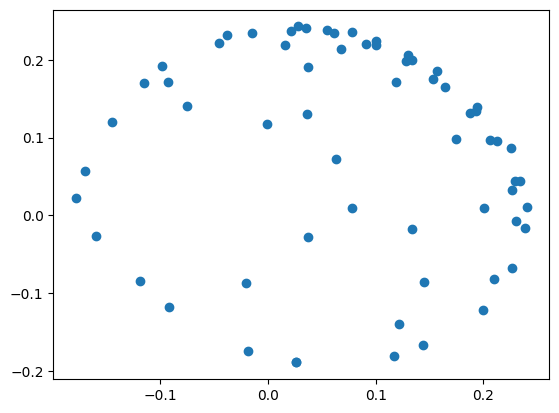

In [6]:
with torch.no_grad():
    inputs = torch.arange(63)[:,None,None]
    print(inputs.shape)
    latents = encoder2(inputs, mask=torch.ones(inputs.shape[:2], dtype=torch.bool))
    
proj = latents.tensor

plt.scatter(proj[:,0], proj[:,1])

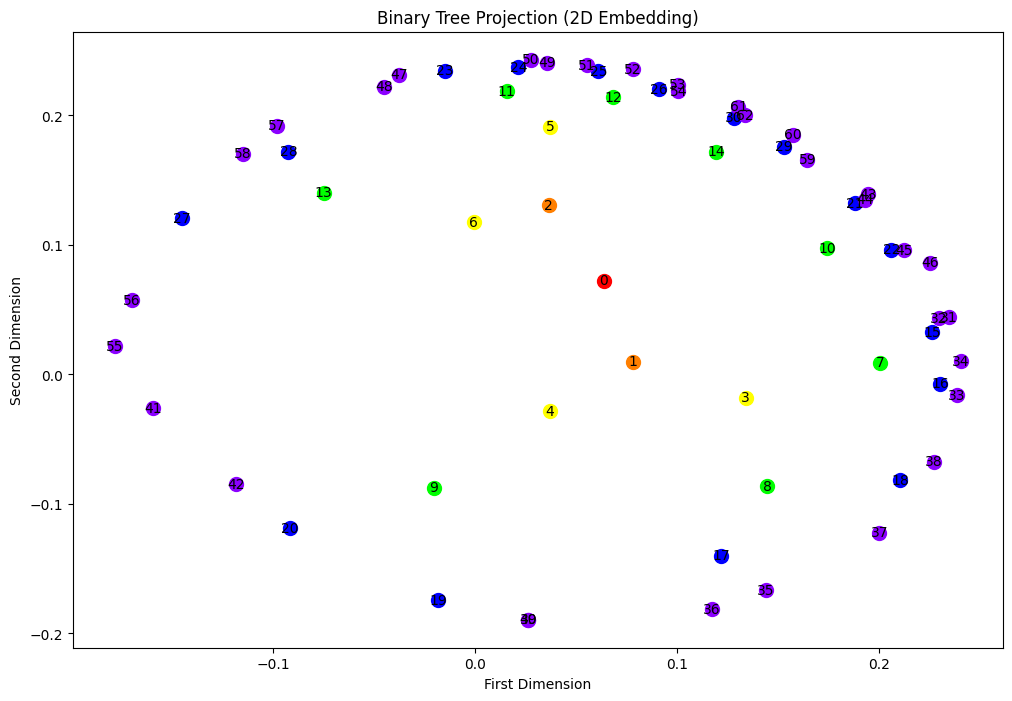

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_binary_tree_embedding(proj):
    levels = 6
    nodes = 2**levels - 1
    
    plt.figure(figsize=(12, 8))
    
    # Color mapping based on level
    colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#8B00FF']
    
    for i in range(nodes):
        level = int(np.floor(np.log2(i + 1)))
        plt.scatter(proj[i, 0], proj[i, 1], c=colors[level], s=100)
        plt.text(proj[i, 0], proj[i, 1], str(i), ha='center', va='center')
    
    plt.title('Binary Tree Projection (2D Embedding)')
    plt.xlabel('First Dimension')
    plt.ylabel('Second Dimension')
    plt.show()

# Assuming proj is your data from the previous code
plot_binary_tree_embedding(proj)

In [28]:
a = torch.tensor(dataset[2][0])[None,:]

a

tensor([[[7]]])